In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
import os
import pandas as pd
import numpy as np
from scipy import stats, linalg
from sklearn import preprocessing, decomposition, linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
from itertools import cycle

In [2]:
n_classes = 3

In [3]:
target_names = ['Asian', 'Black', 'White']

## HCP race prediction using pre-trained normative model deviation scores

In [4]:
df_ct_hcp = pd.read_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/pretrained_nm_z_demos_hcp.csv')

In [5]:
hcp_drop = ['Mixed', 'Unknown']

In [6]:
df_ct_hcp = df_ct_hcp[~df_ct_hcp.Race.isin(hcp_drop)]

In [7]:
df_ct_hcp['race_binary'] = df_ct_hcp['Race']

In [8]:
df_ct_hcp['race_binary'] = df_ct_hcp['race_binary'].replace('Asian',1)

In [9]:
df_ct_hcp['race_binary'] = df_ct_hcp['race_binary'].replace('Black',2)

In [10]:
df_ct_hcp['race_binary'] = df_ct_hcp['race_binary'].replace('White',3)

In [11]:
data_z = df_ct_hcp.filter(regex='_Z_predict',axis=1)

In [12]:
z_npy = np.array(data_z)

In [13]:
race_binary = np.array(df_ct_hcp['race_binary'])

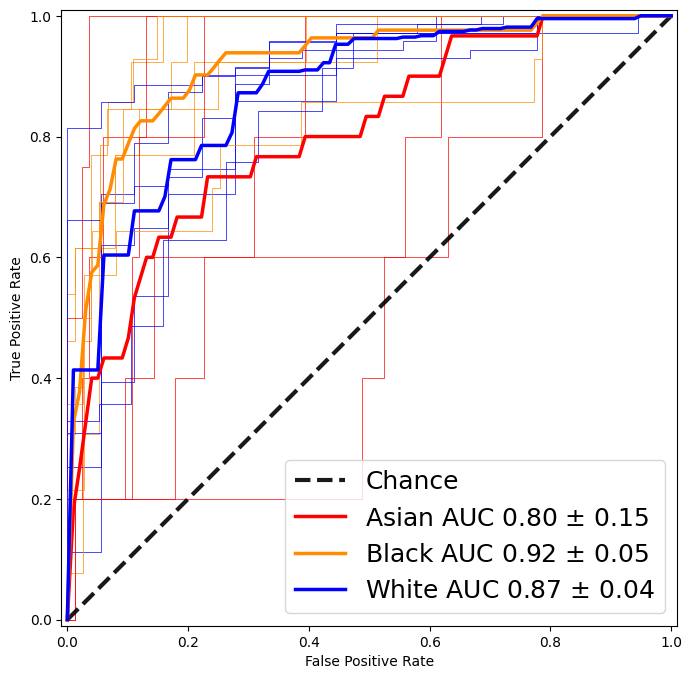

In [14]:
random_state = np.random.RandomState(0)
n_splits = 6
cv = StratifiedKFold(n_splits=n_splits)
#classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
classifier = LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
precision_recall = []
conf_mat_arr = []

fig, ax = plt.subplots(figsize=(8,8))
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 25, 'xtick.labelsize':20,'ytick.labelsize':20,'legend.fontsize':18,'legend.title_fontsize':16}
plt.rcParams.update(parameters)

for fold, (train, test) in enumerate(cv.split(z_npy, race_binary)):
    label_binarizer = LabelBinarizer().fit(race_binary[train])
    y_onehot_test = label_binarizer.transform(race_binary[test])
    classifier.fit(z_npy[train], race_binary[train])
    y_score = classifier.fit(z_npy[train], race_binary[train]).predict(z_npy[test])
    precision_recall_var = precision_recall_fscore_support(race_binary[test], y_score)
    precision_recall.append(precision_recall_var)
    conf_mat = confusion_matrix(race_binary[test], y_score, normalize="true")
    y_score = classifier.fit(z_npy[train], race_binary[train]).predict_proba(z_npy[test])
    colors = cycle(["red", "darkorange", "blue"])
    for class_id, color in zip(range(n_classes), colors):
        viz = RocCurveDisplay.from_predictions(
                y_onehot_test[:, class_id],
                y_score[:, class_id],
                name=f"{target_names[class_id]}, Fold: {fold}",
                lw=0.5,
                color=color, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        conf_mat_arr.append(conf_mat)

    
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='black',
        label='Chance', alpha=.9)

asian_aucs = aucs[0::3]
black_aucs = aucs[1::3]
white_aucs = aucs[2::3]

asian_tprs = tprs[0::3]
black_tprs = tprs[1::3]
white_tprs = tprs[2::3]

mean_tpr_asian = np.mean(asian_tprs, axis=0)
mean_tpr_asian[-1] = 1.0
mean_auc_asian = auc(mean_fpr, mean_tpr_asian)
std_auc_asian = np.std(asian_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_asian,
    color="red",
    label=r"Asian AUC %0.2f $\pm$ %0.2f" % (mean_auc_asian, std_auc_asian),
    lw=2.5
)

mean_tpr_black = np.mean(black_tprs, axis=0)
mean_tpr_black[-1] = 1.0
mean_auc_black = auc(mean_fpr, mean_tpr_black)
std_auc_black = np.std(black_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_black,
    color="darkorange",
    label=r"Black AUC %0.2f $\pm$ %0.2f" % (mean_auc_black, std_auc_black),
    lw=2.5
)

mean_tpr_white = np.mean(white_tprs, axis=0)
mean_tpr_white[-1] = 1.0
mean_auc_white = auc(mean_fpr, mean_tpr_white)
std_auc_white = np.std(white_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_white,
    color="blue",
    label=r"White AUC %0.2f $\pm$ %0.2f" % (mean_auc_white, std_auc_white),
    lw=2.5
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[18:], labels[18:], loc="lower right")

plt.show()

In [15]:
cm = np.mean(conf_mat_arr[0::3], axis=0)

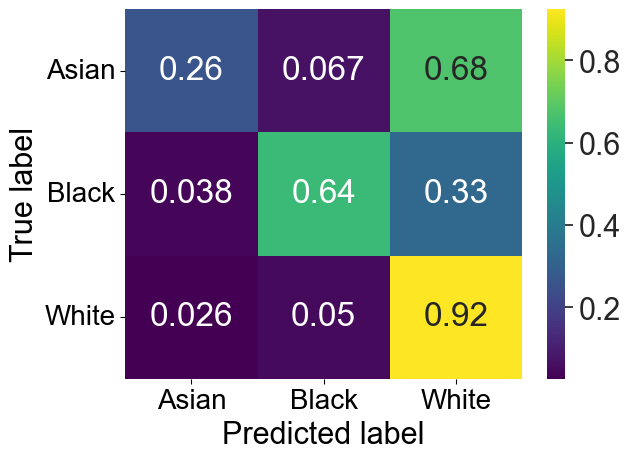

In [16]:
ax = plt.subplot()
sns.set(style="white", font_scale=2.0) # Adjust to fit
g = sns.heatmap(cm, annot=True, ax=ax, cmap='viridis', xticklabels=['Asian', 'Black', 'White']);  
label_font = {'size':'22'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
g.set_yticklabels(labels=['Asian', 'Black', 'White'], rotation=0) 

plt.show()

In [17]:
precision_a_arr = []
recall_a_arr = []
fscore_a_arr = []

precision_b_arr = []
recall_b_arr = []
fscore_b_arr = []

precision_w_arr = []
recall_w_arr = []
fscore_w_arr = []

for i in range(6):
    precision_a = precision_recall[i][0][0]
    precision_b = precision_recall[i][0][1]
    precision_w = precision_recall[i][0][2]

    recall_a = precision_recall[i][1][0]
    recall_b = precision_recall[i][1][1]
    recall_w = precision_recall[i][1][2]

    fscore_a = precision_recall[i][2][0]
    fscore_b = precision_recall[i][2][1]
    fscore_w = precision_recall[i][2][2]

    precision_a_arr.append(precision_a)
    recall_a_arr.append(recall_a)
    fscore_a_arr.append(fscore_a)
    
    precision_b_arr.append(precision_b)
    recall_b_arr.append(recall_b)
    fscore_b_arr.append(fscore_b)
    
    precision_w_arr.append(precision_w)
    recall_w_arr.append(recall_w)
    fscore_w_arr.append(fscore_w)

In [18]:
np.mean(precision_a_arr)

0.3055555555555555

In [19]:
np.std(precision_a_arr)

0.20038543107634926

In [20]:
np.mean(recall_a_arr)

0.25833333333333336

In [21]:
np.std(recall_a_arr)

0.23169064624096408

In [22]:
np.mean(fscore_a_arr)

0.26706349206349206

In [23]:
np.std(fscore_a_arr)

0.20026634130027424

In [24]:
np.mean(precision_b_arr)

0.6895639083139083

In [25]:
np.std(precision_b_arr)

0.03217206534999426

In [26]:
np.mean(recall_b_arr)

0.6364468864468864

In [27]:
np.std(recall_b_arr)

0.08176891661638463

In [28]:
np.mean(fscore_b_arr)

0.6592735042735043

In [29]:
np.std(fscore_b_arr)

0.04679854023009124

In [30]:
np.mean(precision_w_arr)

0.8957815464853095

In [31]:
np.std(precision_w_arr)

0.023069758032197858

In [32]:
np.mean(recall_w_arr)

0.924446680080483

In [33]:
np.std(recall_w_arr)

0.017993429539497924

In [34]:
np.mean(fscore_w_arr)

0.9095644367411834

In [35]:
np.std(fscore_w_arr)

0.011450537459321961

## UKB race prediction using pre-trained normative model deviation scores

In [36]:
df_ct_ukb = pd.read_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/pretrained_nm_z_demos_ukb.csv')

In [37]:
df_ct_ukb['race_1'].value_counts()

White    13175
Black      123
Asian      118
Name: race_1, dtype: int64

In [38]:
df_ct_ukb['race_binary'] = df_ct_ukb['race_1']

In [39]:
df_ct_ukb['race_binary'] = df_ct_ukb['race_binary'].replace('Asian',1)

In [40]:
df_ct_ukb['race_binary'] = df_ct_ukb['race_binary'].replace('Black',2)

In [41]:
df_ct_ukb['race_binary'] = df_ct_ukb['race_binary'].replace('White',3)

In [42]:
data_z = df_ct_ukb.filter(regex='_Z_predict',axis=1)

In [43]:
z_npy = np.array(data_z)

In [44]:
race_binary = np.array(df_ct_ukb['race_binary'])

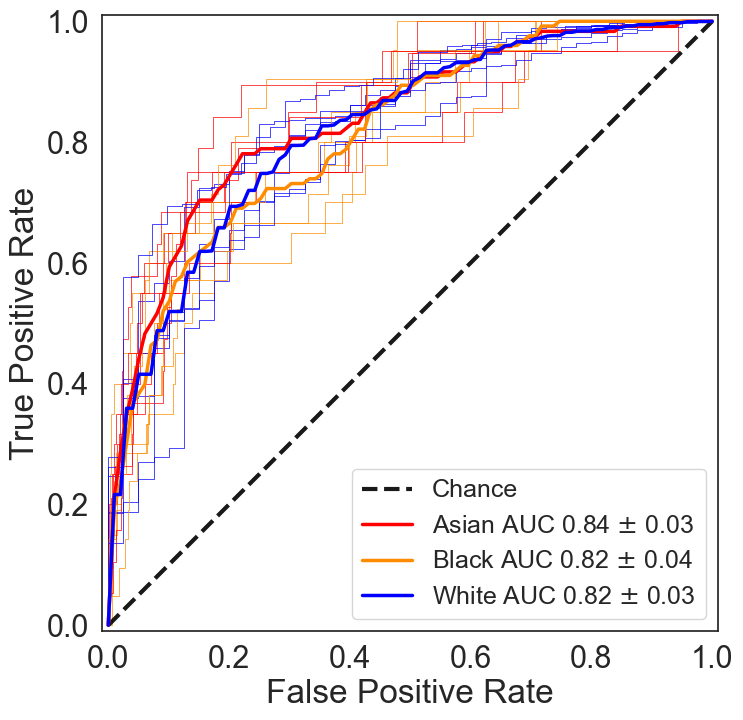

In [45]:
random_state = np.random.RandomState(0)
n_splits = 6
cv = StratifiedKFold(n_splits=n_splits)
#classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
classifier = LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
precision_recall = []
conf_mat_arr = []

fig, ax = plt.subplots(figsize=(8,8))
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 25, 'xtick.labelsize':20,'ytick.labelsize':20,'legend.fontsize':18,'legend.title_fontsize':16}
plt.rcParams.update(parameters)

for fold, (train, test) in enumerate(cv.split(z_npy, race_binary)):
    label_binarizer = LabelBinarizer().fit(race_binary[train])
    y_onehot_test = label_binarizer.transform(race_binary[test])
    classifier.fit(z_npy[train], race_binary[train])
    y_score = classifier.fit(z_npy[train], race_binary[train]).predict(z_npy[test])
    precision_recall_var = precision_recall_fscore_support(race_binary[test], y_score)
    precision_recall.append(precision_recall_var)
    conf_mat = confusion_matrix(race_binary[test], y_score, normalize="true")
    y_score = classifier.fit(z_npy[train], race_binary[train]).predict_proba(z_npy[test])
    colors = cycle(["red", "darkorange", "blue"])
    for class_id, color in zip(range(n_classes), colors):
        viz = RocCurveDisplay.from_predictions(
                y_onehot_test[:, class_id],
                y_score[:, class_id],
                name=f"{target_names[class_id]}, Fold: {fold}",
                lw=0.5,
                color=color, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        conf_mat_arr.append(conf_mat)

    
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='black',
        label='Chance', alpha=.9)

asian_aucs = aucs[0::3]
black_aucs = aucs[1::3]
white_aucs = aucs[2::3]

asian_tprs = tprs[0::3]
black_tprs = tprs[1::3]
white_tprs = tprs[2::3]

mean_tpr_asian = np.mean(asian_tprs, axis=0)
mean_tpr_asian[-1] = 1.0
mean_auc_asian = auc(mean_fpr, mean_tpr_asian)
std_auc_asian = np.std(asian_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_asian,
    color="red",
    label=r"Asian AUC %0.2f $\pm$ %0.2f" % (mean_auc_asian, std_auc_asian),
    lw=2.5
)

mean_tpr_black = np.mean(black_tprs, axis=0)
mean_tpr_black[-1] = 1.0
mean_auc_black = auc(mean_fpr, mean_tpr_black)
std_auc_black = np.std(black_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_black,
    color="darkorange",
    label=r"Black AUC %0.2f $\pm$ %0.2f" % (mean_auc_black, std_auc_black),
    lw=2.5
)

mean_tpr_white = np.mean(white_tprs, axis=0)
mean_tpr_white[-1] = 1.0
mean_auc_white = auc(mean_fpr, mean_tpr_white)
std_auc_white = np.std(white_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_white,
    color="blue",
    label=r"White AUC %0.2f $\pm$ %0.2f" % (mean_auc_white, std_auc_white),
    lw=2.5
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[18:], labels[18:], loc="lower right")

plt.show()

In [46]:
cm = np.mean(conf_mat_arr[0::3], axis=0)

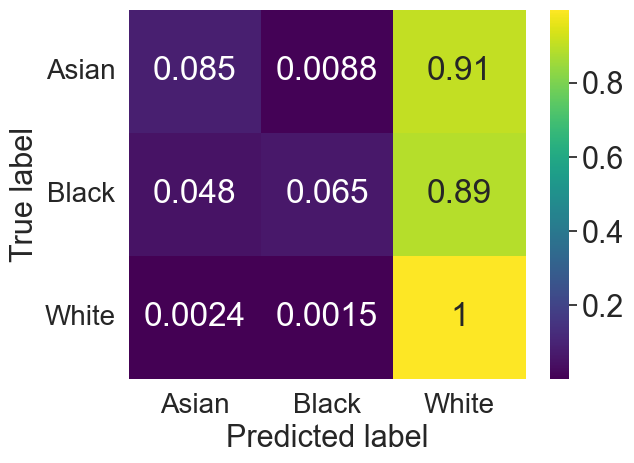

In [47]:
ax = plt.subplot()
sns.set(style="white", font_scale=2.0) # Adjust to fit
g = sns.heatmap(cm, annot=True, ax=ax, cmap='viridis', xticklabels=['Asian', 'Black', 'White']);  
label_font = {'size':'22'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
g.set_yticklabels(labels=['Asian', 'Black', 'White'], rotation=0) 

plt.show()

In [48]:
precision_a_arr = []
recall_a_arr = []
fscore_a_arr = []

precision_b_arr = []
recall_b_arr = []
fscore_b_arr = []

precision_w_arr = []
recall_w_arr = []
fscore_w_arr = []

for i in range(6):
    precision_a = precision_recall[i][0][0]
    precision_b = precision_recall[i][0][1]
    precision_w = precision_recall[i][0][2]

    recall_a = precision_recall[i][1][0]
    recall_b = precision_recall[i][1][1]
    recall_w = precision_recall[i][1][2]

    fscore_a = precision_recall[i][2][0]
    fscore_b = precision_recall[i][2][1]
    fscore_w = precision_recall[i][2][2]

    precision_a_arr.append(precision_a)
    recall_a_arr.append(recall_a)
    fscore_a_arr.append(fscore_a)
    
    precision_b_arr.append(precision_b)
    recall_b_arr.append(recall_b)
    fscore_b_arr.append(fscore_b)
    
    precision_w_arr.append(precision_w)
    recall_w_arr.append(recall_w)
    fscore_w_arr.append(fscore_w)

In [49]:
np.mean(precision_a_arr)

0.21640211640211637

In [50]:
np.std(precision_a_arr)

0.0901957347613123

In [51]:
np.mean(recall_a_arr)

0.08508771929824561

In [52]:
np.std(recall_a_arr)

0.039288062590453844

In [53]:
np.mean(fscore_a_arr)

0.12100426180885952

In [54]:
np.std(fscore_a_arr)

0.05310392201437208

In [55]:
np.mean(precision_b_arr)

0.3055555555555555

In [56]:
np.std(precision_b_arr)

0.3356401659331825

In [57]:
np.mean(recall_b_arr)

0.06507936507936508

In [58]:
np.std(recall_b_arr)

0.06091496040471989

In [59]:
np.mean(fscore_b_arr)

0.10337164750957854

In [60]:
np.std(fscore_b_arr)

0.09533838201088093

In [61]:
np.mean(precision_w_arr)

0.9838087539276618

In [62]:
np.std(precision_w_arr)

0.0008076555429860231

In [63]:
np.mean(recall_w_arr)

0.9961291185879482

In [64]:
np.std(recall_w_arr)

0.0006827144136515807

In [65]:
np.mean(fscore_w_arr)

0.9899303408527681

In [66]:
np.std(fscore_w_arr)

0.0005483440088626658

## HCP race prediction using white-only training normative model deviation scores

In [67]:
df_z = pd.read_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_not_modeled/deviation_scores.csv')

In [68]:
demos_hcp = pd.read_csv('/Users/saigerutherford/Documents/Work/NM_demo/demos_short_hcp.csv')

In [69]:
df_z = df_z.dropna(axis=1, how='any')

In [70]:
df_ct_hcp = pd.merge(demos_hcp, df_z, how='inner')

In [71]:
df_ct_hcp['race_binary'] = df_ct_hcp['Race']

In [72]:
df_ct_hcp['race_binary'] = df_ct_hcp['race_binary'].replace('Asian',1)

In [73]:
df_ct_hcp['race_binary'] = df_ct_hcp['race_binary'].replace('Black',2)

In [74]:
df_ct_hcp['race_binary'] = df_ct_hcp['race_binary'].replace('White',3)

In [75]:
data_z = df_ct_hcp.filter(regex='_Z_estimate',axis=1)

In [76]:
z_npy = np.array(data_z)

In [77]:
race_binary = np.array(df_ct_hcp['race_binary'])

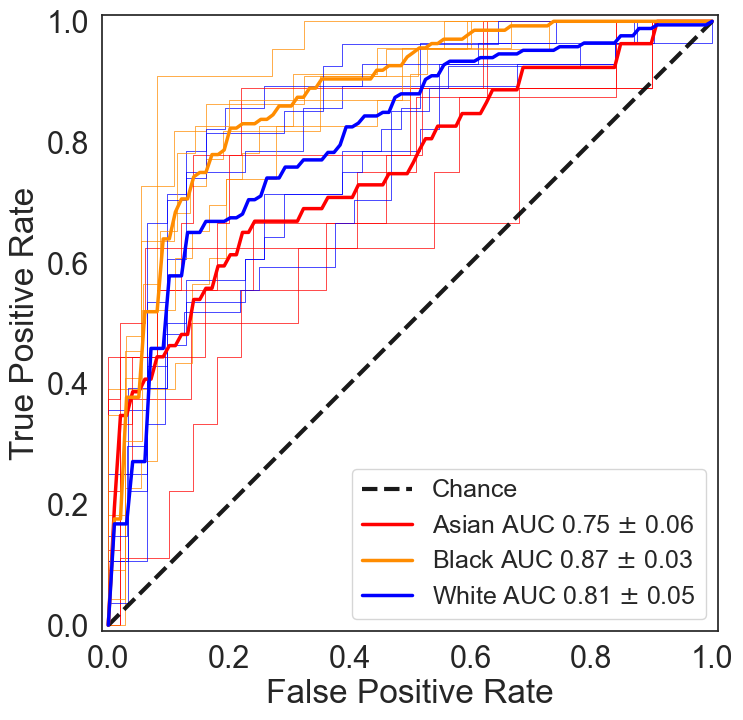

In [78]:
random_state = np.random.RandomState(0)
n_splits = 6
cv = StratifiedKFold(n_splits=n_splits)
#classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
classifier = LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
precision_recall = []
conf_mat_arr = []

fig, ax = plt.subplots(figsize=(8,8))
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 25, 'xtick.labelsize':20,'ytick.labelsize':20,'legend.fontsize':18,'legend.title_fontsize':16}
plt.rcParams.update(parameters)

for fold, (train, test) in enumerate(cv.split(z_npy, race_binary)):
    label_binarizer = LabelBinarizer().fit(race_binary[train])
    y_onehot_test = label_binarizer.transform(race_binary[test])
    classifier.fit(z_npy[train], race_binary[train])
    y_score = classifier.fit(z_npy[train], race_binary[train]).predict(z_npy[test])
    precision_recall_var = precision_recall_fscore_support(race_binary[test], y_score)
    precision_recall.append(precision_recall_var)
    conf_mat = confusion_matrix(race_binary[test], y_score, normalize="true")
    y_score = classifier.fit(z_npy[train], race_binary[train]).predict_proba(z_npy[test])
    colors = cycle(["red", "darkorange", "blue"])
    for class_id, color in zip(range(n_classes), colors):
        viz = RocCurveDisplay.from_predictions(
                y_onehot_test[:, class_id],
                y_score[:, class_id],
                name=f"{target_names[class_id]}, Fold: {fold}",
                lw=0.5,
                color=color, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        conf_mat_arr.append(conf_mat)

    
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='black',
        label='Chance', alpha=.9)

asian_aucs = aucs[0::3]
black_aucs = aucs[1::3]
white_aucs = aucs[2::3]

asian_tprs = tprs[0::3]
black_tprs = tprs[1::3]
white_tprs = tprs[2::3]

mean_tpr_asian = np.mean(asian_tprs, axis=0)
mean_tpr_asian[-1] = 1.0
mean_auc_asian = auc(mean_fpr, mean_tpr_asian)
std_auc_asian = np.std(asian_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_asian,
    color="red",
    label=r"Asian AUC %0.2f $\pm$ %0.2f" % (mean_auc_asian, std_auc_asian),
    lw=2.5
)

mean_tpr_black = np.mean(black_tprs, axis=0)
mean_tpr_black[-1] = 1.0
mean_auc_black = auc(mean_fpr, mean_tpr_black)
std_auc_black = np.std(black_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_black,
    color="darkorange",
    label=r"Black AUC %0.2f $\pm$ %0.2f" % (mean_auc_black, std_auc_black),
    lw=2.5
)

mean_tpr_white = np.mean(white_tprs, axis=0)
mean_tpr_white[-1] = 1.0
mean_auc_white = auc(mean_fpr, mean_tpr_white)
std_auc_white = np.std(white_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_white,
    color="blue",
    label=r"White AUC %0.2f $\pm$ %0.2f" % (mean_auc_white, std_auc_white),
    lw=2.5
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[18:], labels[18:], loc="lower right")

plt.show()

In [132]:
cm = np.mean(conf_mat_arr[0::3], axis=0)

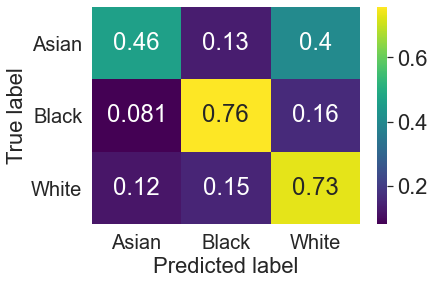

In [133]:
ax = plt.subplot()
sns.set(style="white", font_scale=2.0) # Adjust to fit
g = sns.heatmap(cm, annot=True, ax=ax, cmap='viridis', xticklabels=['Asian', 'Black', 'White']);  
label_font = {'size':'22'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
g.set_yticklabels(labels=['Asian', 'Black', 'White'], rotation=0) 

plt.show()

In [134]:
precision_a_arr = []
recall_a_arr = []
fscore_a_arr = []

precision_b_arr = []
recall_b_arr = []
fscore_b_arr = []

precision_w_arr = []
recall_w_arr = []
fscore_w_arr = []

for i in range(6):
    precision_a = precision_recall[i][0][0]
    precision_b = precision_recall[i][0][1]
    precision_w = precision_recall[i][0][2]

    recall_a = precision_recall[i][1][0]
    recall_b = precision_recall[i][1][1]
    recall_w = precision_recall[i][1][2]

    fscore_a = precision_recall[i][2][0]
    fscore_b = precision_recall[i][2][1]
    fscore_w = precision_recall[i][2][2]

    precision_a_arr.append(precision_a)
    recall_a_arr.append(recall_a)
    fscore_a_arr.append(fscore_a)
    
    precision_b_arr.append(precision_b)
    recall_b_arr.append(recall_b)
    fscore_b_arr.append(fscore_b)
    
    precision_w_arr.append(precision_w)
    recall_w_arr.append(recall_w)
    fscore_w_arr.append(fscore_w)

In [135]:
np.mean(precision_a_arr)

0.4305555555555555

In [136]:
np.std(precision_a_arr)

0.10111263735111833

In [137]:
np.mean(recall_a_arr)

0.46296296296296297

In [138]:
np.std(recall_a_arr)

0.14951625242551056

In [139]:
np.mean(fscore_a_arr)

0.4427326486150016

In [140]:
np.std(fscore_a_arr)

0.11685943757197352

In [141]:
np.mean(precision_b_arr)

0.7643009164748295

In [142]:
np.std(precision_b_arr)

0.06702652769738095

In [143]:
np.mean(recall_b_arr)

0.7565876152832675

In [144]:
np.std(recall_b_arr)

0.0678532368808192

In [145]:
np.mean(fscore_b_arr)

0.759374235952309

In [146]:
np.std(fscore_b_arr)

0.06222912760274014

In [147]:
np.mean(precision_w_arr)

0.7418738977072309

In [148]:
np.std(precision_w_arr)

0.08961710714713417

In [149]:
np.mean(recall_w_arr)

0.7290564373897706

In [150]:
np.std(recall_w_arr)

0.07670215344737277

In [151]:
np.mean(fscore_w_arr)

0.7339627483434056

In [152]:
np.std(fscore_w_arr)

0.07796654115239669

## HCP race prediction using white-only training normative model deviation scores (race included)

In [153]:
df_z = pd.read_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/hcp_race_modeled/deviation_scores.csv')

In [154]:
demos_hcp = pd.read_csv('/Users/saigerutherford/Documents/Work/NM_demo/demos_short_hcp.csv')

In [155]:
df_z = df_z.dropna(axis=1, how='any')

In [156]:
df_ct_hcp = pd.merge(demos_hcp, df_z, how='inner')

In [157]:
df_ct_hcp.shape

(353, 188)

In [158]:
df_ct_hcp['Race'].value_counts()

White    166
Black    135
Asian     52
Name: Race, dtype: int64

In [159]:
df_ct_hcp['race_binary'] = df_ct_hcp['Race']

In [160]:
df_ct_hcp['race_binary'] = df_ct_hcp['race_binary'].replace('Asian',1)

In [161]:
df_ct_hcp['race_binary'] = df_ct_hcp['race_binary'].replace('Black',2)

In [162]:
df_ct_hcp['race_binary'] = df_ct_hcp['race_binary'].replace('White',3)

In [163]:
data_z = df_ct_hcp.filter(regex='_Z_estimate',axis=1)

In [164]:
z_npy = np.array(data_z)

In [165]:
race_binary = np.array(df_ct_hcp['race_binary'])

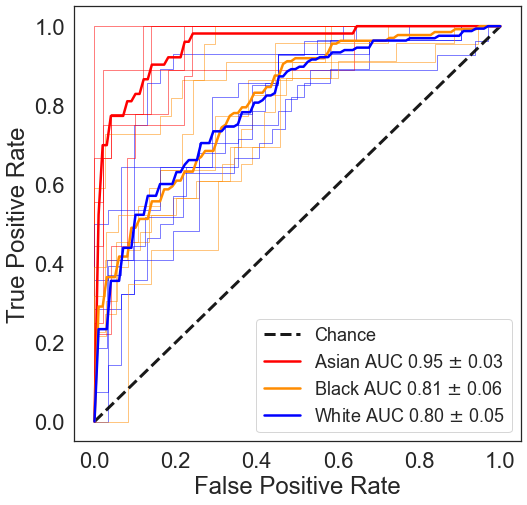

In [166]:
random_state = np.random.RandomState(0)
n_splits = 6
cv = StratifiedKFold(n_splits=n_splits)
#classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
classifier = LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
precision_recall = []
conf_mat_arr = []

fig, ax = plt.subplots(figsize=(8,8))
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 25, 'xtick.labelsize':20,'ytick.labelsize':20,'legend.fontsize':18,'legend.title_fontsize':16}
plt.rcParams.update(parameters)

for fold, (train, test) in enumerate(cv.split(z_npy, race_binary)):
    label_binarizer = LabelBinarizer().fit(race_binary[train])
    y_onehot_test = label_binarizer.transform(race_binary[test])
    classifier.fit(z_npy[train], race_binary[train])
    y_score = classifier.fit(z_npy[train], race_binary[train]).predict(z_npy[test])
    precision_recall_var = precision_recall_fscore_support(race_binary[test], y_score)
    precision_recall.append(precision_recall_var)
    conf_mat = confusion_matrix(race_binary[test], y_score, normalize="true")
    y_score = classifier.fit(z_npy[train], race_binary[train]).predict_proba(z_npy[test])
    colors = cycle(["red", "darkorange", "blue"])
    for class_id, color in zip(range(n_classes), colors):
        viz = RocCurveDisplay.from_predictions(
                y_onehot_test[:, class_id],
                y_score[:, class_id],
                name=f"{target_names[class_id]}, Fold: {fold}",
                lw=0.5,
                color=color, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        conf_mat_arr.append(conf_mat)

    
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='black',
        label='Chance', alpha=.9)

asian_aucs = aucs[0::3]
black_aucs = aucs[1::3]
white_aucs = aucs[2::3]

asian_tprs = tprs[0::3]
black_tprs = tprs[1::3]
white_tprs = tprs[2::3]

mean_tpr_asian = np.mean(asian_tprs, axis=0)
mean_tpr_asian[-1] = 1.0
mean_auc_asian = auc(mean_fpr, mean_tpr_asian)
std_auc_asian = np.std(asian_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_asian,
    color="red",
    label=r"Asian AUC %0.2f $\pm$ %0.2f" % (mean_auc_asian, std_auc_asian),
    lw=2.5
)

mean_tpr_black = np.mean(black_tprs, axis=0)
mean_tpr_black[-1] = 1.0
mean_auc_black = auc(mean_fpr, mean_tpr_black)
std_auc_black = np.std(black_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_black,
    color="darkorange",
    label=r"Black AUC %0.2f $\pm$ %0.2f" % (mean_auc_black, std_auc_black),
    lw=2.5
)

mean_tpr_white = np.mean(white_tprs, axis=0)
mean_tpr_white[-1] = 1.0
mean_auc_white = auc(mean_fpr, mean_tpr_white)
std_auc_white = np.std(white_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_white,
    color="blue",
    label=r"White AUC %0.2f $\pm$ %0.2f" % (mean_auc_white, std_auc_white),
    lw=2.5
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[18:], labels[18:], loc="lower right")

plt.show()

In [167]:
cm = np.mean(conf_mat_arr[0::3], axis=0)

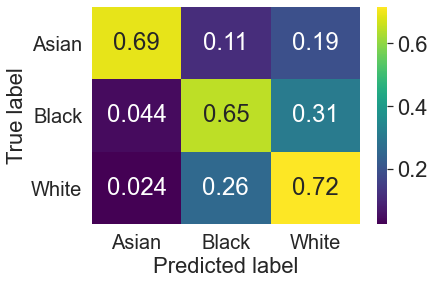

In [168]:
ax = plt.subplot()
sns.set(style="white", font_scale=2.0) # Adjust to fit
g = sns.heatmap(cm, annot=True, ax=ax, cmap='viridis', xticklabels=['Asian', 'Black', 'White']);  
label_font = {'size':'22'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
g.set_yticklabels(labels=['Asian', 'Black', 'White'], rotation=0) 

plt.show()

In [169]:
precision_a_arr = []
recall_a_arr = []
fscore_a_arr = []

precision_b_arr = []
recall_b_arr = []
fscore_b_arr = []

precision_w_arr = []
recall_w_arr = []
fscore_w_arr = []

for i in range(6):
    precision_a = precision_recall[i][0][0]
    precision_b = precision_recall[i][0][1]
    precision_w = precision_recall[i][0][2]

    recall_a = precision_recall[i][1][0]
    recall_b = precision_recall[i][1][1]
    recall_w = precision_recall[i][1][2]

    fscore_a = precision_recall[i][2][0]
    fscore_b = precision_recall[i][2][1]
    fscore_w = precision_recall[i][2][2]

    precision_a_arr.append(precision_a)
    recall_a_arr.append(recall_a)
    fscore_a_arr.append(fscore_a)
    
    precision_b_arr.append(precision_b)
    recall_b_arr.append(recall_b)
    fscore_b_arr.append(fscore_b)
    
    precision_w_arr.append(precision_w)
    recall_w_arr.append(recall_w)
    fscore_w_arr.append(fscore_w)

In [170]:
np.mean(precision_a_arr)

0.7896825396825397

In [171]:
np.std(precision_a_arr)

0.15725171260431475

In [172]:
np.mean(recall_a_arr)

0.6921296296296297

In [173]:
np.std(recall_a_arr)

0.13898530603961182

In [174]:
np.mean(fscore_a_arr)

0.7351774042950514

In [175]:
np.std(fscore_a_arr)

0.1385871824711206

In [176]:
np.mean(precision_b_arr)

0.6456446192108624

In [177]:
np.std(precision_b_arr)

0.09343440588280441

In [178]:
np.mean(recall_b_arr)

0.646574440052701

In [179]:
np.std(recall_b_arr)

0.11579080822809956

In [180]:
np.mean(fscore_b_arr)

0.6409102627023302

In [181]:
np.std(fscore_b_arr)

0.08827010424001813

In [182]:
np.mean(precision_w_arr)

0.7022482021640507

In [183]:
np.std(precision_w_arr)

0.0796562974758391

In [184]:
np.mean(recall_w_arr)

0.7164902998236332

In [185]:
np.std(recall_w_arr)

0.08729045232108189

In [186]:
np.mean(fscore_w_arr)

0.7056147449324707

In [187]:
np.std(fscore_w_arr)

0.06711538290750894

## UKB race prediction using white-only training normative model deviation scores

In [188]:
df_z = pd.read_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/ukb_race_not_modeled/deviation_scores.csv')

In [189]:
demos_ukb = pd.read_csv('/Users/saigerutherford/Documents/Work/NM_demo/demos_short_ukb.csv')

In [190]:
df_z = df_z.dropna(axis=1, how='any')

In [191]:
df_z['sub_id'] = df_z['participant_id']

In [192]:
df_ct_ukb = pd.merge(demos_ukb, df_z, how='inner')

In [193]:
df_ct_ukb['race_binary'] = df_ct_ukb['race_1']

In [194]:
df_ct_ukb['race_binary'] = df_ct_ukb['race_binary'].replace('Asian',1)

In [195]:
df_ct_ukb['race_binary'] = df_ct_ukb['race_binary'].replace('Black',2)

In [196]:
df_ct_ukb['race_binary'] = df_ct_ukb['race_binary'].replace('White',3)

In [197]:
data_z = df_ct_ukb.filter(regex='_Z_estimate',axis=1)

In [198]:
z_npy = np.array(data_z)

In [199]:
race_binary = np.array(df_ct_ukb['race_binary'])

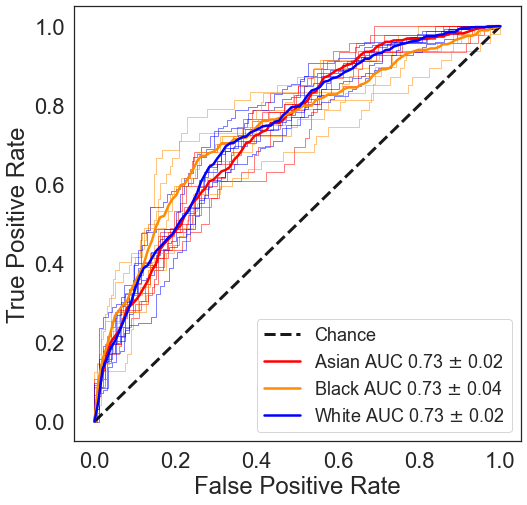

In [200]:
random_state = np.random.RandomState(0)
n_splits = 6
cv = StratifiedKFold(n_splits=n_splits)
#classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
classifier = LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
precision_recall = []
conf_mat_arr = []

fig, ax = plt.subplots(figsize=(8,8))
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 25, 'xtick.labelsize':20,'ytick.labelsize':20,'legend.fontsize':18,'legend.title_fontsize':16}
plt.rcParams.update(parameters)

for fold, (train, test) in enumerate(cv.split(z_npy, race_binary)):
    label_binarizer = LabelBinarizer().fit(race_binary[train])
    y_onehot_test = label_binarizer.transform(race_binary[test])
    classifier.fit(z_npy[train], race_binary[train])
    y_score = classifier.fit(z_npy[train], race_binary[train]).predict(z_npy[test])
    precision_recall_var = precision_recall_fscore_support(race_binary[test], y_score)
    precision_recall.append(precision_recall_var)
    conf_mat = confusion_matrix(race_binary[test], y_score, normalize="true")
    y_score = classifier.fit(z_npy[train], race_binary[train]).predict_proba(z_npy[test])
    colors = cycle(["red", "darkorange", "blue"])
    for class_id, color in zip(range(n_classes), colors):
        viz = RocCurveDisplay.from_predictions(
                y_onehot_test[:, class_id],
                y_score[:, class_id],
                name=f"{target_names[class_id]}, Fold: {fold}",
                lw=0.5,
                color=color, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        conf_mat_arr.append(conf_mat)

    
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='black',
        label='Chance', alpha=.9)

asian_aucs = aucs[0::3]
black_aucs = aucs[1::3]
white_aucs = aucs[2::3]

asian_tprs = tprs[0::3]
black_tprs = tprs[1::3]
white_tprs = tprs[2::3]

mean_tpr_asian = np.mean(asian_tprs, axis=0)
mean_tpr_asian[-1] = 1.0
mean_auc_asian = auc(mean_fpr, mean_tpr_asian)
std_auc_asian = np.std(asian_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_asian,
    color="red",
    label=r"Asian AUC %0.2f $\pm$ %0.2f" % (mean_auc_asian, std_auc_asian),
    lw=2.5
)

mean_tpr_black = np.mean(black_tprs, axis=0)
mean_tpr_black[-1] = 1.0
mean_auc_black = auc(mean_fpr, mean_tpr_black)
std_auc_black = np.std(black_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_black,
    color="darkorange",
    label=r"Black AUC %0.2f $\pm$ %0.2f" % (mean_auc_black, std_auc_black),
    lw=2.5
)

mean_tpr_white = np.mean(white_tprs, axis=0)
mean_tpr_white[-1] = 1.0
mean_auc_white = auc(mean_fpr, mean_tpr_white)
std_auc_white = np.std(white_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_white,
    color="blue",
    label=r"White AUC %0.2f $\pm$ %0.2f" % (mean_auc_white, std_auc_white),
    lw=2.5
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[18:], labels[18:], loc="lower right")

plt.show()

In [201]:
cm = np.mean(conf_mat_arr[0::3], axis=0)

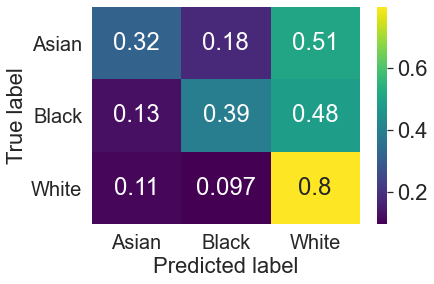

In [202]:
ax = plt.subplot()
sns.set(style="white", font_scale=2.0) # Adjust to fit
g = sns.heatmap(cm, annot=True, ax=ax, cmap='viridis', xticklabels=['Asian', 'Black', 'White']);  
label_font = {'size':'22'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
g.set_yticklabels(labels=['Asian', 'Black', 'White'], rotation=0) 

plt.show()

In [203]:
precision_a_arr = []
recall_a_arr = []
fscore_a_arr = []

precision_b_arr = []
recall_b_arr = []
fscore_b_arr = []

precision_w_arr = []
recall_w_arr = []
fscore_w_arr = []

for i in range(6):
    precision_a = precision_recall[i][0][0]
    precision_b = precision_recall[i][0][1]
    precision_w = precision_recall[i][0][2]

    recall_a = precision_recall[i][1][0]
    recall_b = precision_recall[i][1][1]
    recall_w = precision_recall[i][1][2]

    fscore_a = precision_recall[i][2][0]
    fscore_b = precision_recall[i][2][1]
    fscore_w = precision_recall[i][2][2]

    precision_a_arr.append(precision_a)
    recall_a_arr.append(recall_a)
    fscore_a_arr.append(fscore_a)
    
    precision_b_arr.append(precision_b)
    recall_b_arr.append(recall_b)
    fscore_b_arr.append(fscore_b)
    
    precision_w_arr.append(precision_w)
    recall_w_arr.append(recall_w)
    fscore_w_arr.append(fscore_w)

In [204]:
np.mean(precision_a_arr)

0.3976473331070494

In [205]:
np.std(precision_a_arr)

0.027449669707649425

In [206]:
np.mean(recall_a_arr)

0.316759173604687

In [207]:
np.std(recall_a_arr)

0.03826983503257892

In [208]:
np.mean(fscore_a_arr)

0.35117615178001826

In [209]:
np.std(fscore_a_arr)

0.027239256845156525

In [210]:
np.mean(precision_b_arr)

0.448953823953824

In [211]:
np.std(precision_b_arr)

0.05232403868262116

In [212]:
np.mean(recall_b_arr)

0.3905141843971631

In [213]:
np.std(recall_b_arr)

0.053047850779053364

In [214]:
np.mean(fscore_b_arr)

0.4164577257556796

In [215]:
np.std(fscore_b_arr)

0.04796589049542753

In [216]:
np.mean(precision_w_arr)

0.7224220332329595

In [217]:
np.std(precision_w_arr)

0.016370514387163942

In [218]:
np.mean(recall_w_arr)

0.7956677704194259

In [219]:
np.std(recall_w_arr)

0.029773979476009224

In [220]:
np.mean(fscore_w_arr)

0.7572001960784546

In [221]:
np.std(fscore_w_arr)

0.02196670270065982

## UKB race prediction using white-only training normative model deviation scores (race included)

In [222]:
df_z = pd.read_csv('/Users/saigerutherford/Documents/Work/drive-download-20220731T221458Z-001/braincharts/models/ukb_race_modeled/deviation_scores.csv')

In [223]:
demos_ukb = pd.read_csv('/Users/saigerutherford/Documents/Work/NM_demo/demos_short_ukb.csv')

In [224]:
df_z = df_z.dropna(axis=1, how='any')

In [225]:
df_z['sub_id'] = df_z['participant_id']

In [226]:
df_ct_ukb = pd.merge(demos_ukb, df_z, how='inner')

In [227]:
df_ct_ukb['race_binary'] = df_ct_ukb['race_1']

In [228]:
df_ct_ukb['race_binary'] = df_ct_ukb['race_binary'].replace('Asian',1)

In [229]:
df_ct_ukb['race_binary'] = df_ct_ukb['race_binary'].replace('Black',2)

In [230]:
df_ct_ukb['race_binary'] = df_ct_ukb['race_binary'].replace('White',3)

In [231]:
data_z = df_ct_ukb.filter(regex='_Z_estimate',axis=1)

In [232]:
z_npy = np.array(data_z)

In [233]:
race_binary = np.array(df_ct_ukb['race_binary'])

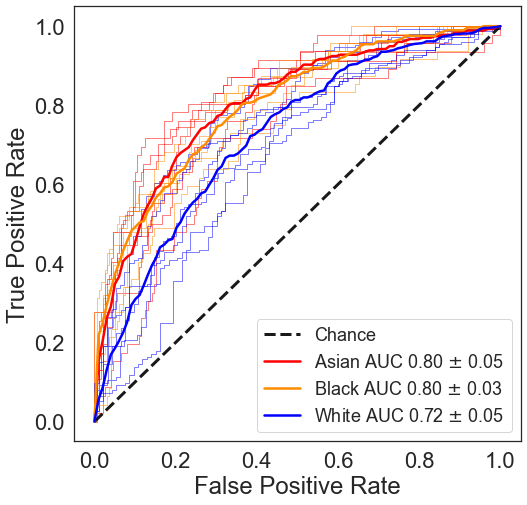

In [234]:
random_state = np.random.RandomState(0)
n_splits = 6
cv = StratifiedKFold(n_splits=n_splits)
#classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
classifier = LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
precision_recall = []
conf_mat_arr = []

fig, ax = plt.subplots(figsize=(8,8))
parameters = {'axes.labelsize': 20,
          'axes.titlesize': 25, 'xtick.labelsize':20,'ytick.labelsize':20,'legend.fontsize':18,'legend.title_fontsize':16}
plt.rcParams.update(parameters)

for fold, (train, test) in enumerate(cv.split(z_npy, race_binary)):
    label_binarizer = LabelBinarizer().fit(race_binary[train])
    y_onehot_test = label_binarizer.transform(race_binary[test])
    classifier.fit(z_npy[train], race_binary[train])
    y_score = classifier.fit(z_npy[train], race_binary[train]).predict(z_npy[test])
    precision_recall_var = precision_recall_fscore_support(race_binary[test], y_score)
    precision_recall.append(precision_recall_var)
    conf_mat = confusion_matrix(race_binary[test], y_score, normalize="true")
    y_score = classifier.fit(z_npy[train], race_binary[train]).predict_proba(z_npy[test])
    colors = cycle(["red", "darkorange", "blue"])
    for class_id, color in zip(range(n_classes), colors):
        viz = RocCurveDisplay.from_predictions(
                y_onehot_test[:, class_id],
                y_score[:, class_id],
                name=f"{target_names[class_id]}, Fold: {fold}",
                lw=0.5,
                color=color, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        conf_mat_arr.append(conf_mat)

    
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='black',
        label='Chance', alpha=.9)

asian_aucs = aucs[0::3]
black_aucs = aucs[1::3]
white_aucs = aucs[2::3]

asian_tprs = tprs[0::3]
black_tprs = tprs[1::3]
white_tprs = tprs[2::3]

mean_tpr_asian = np.mean(asian_tprs, axis=0)
mean_tpr_asian[-1] = 1.0
mean_auc_asian = auc(mean_fpr, mean_tpr_asian)
std_auc_asian = np.std(asian_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_asian,
    color="red",
    label=r"Asian AUC %0.2f $\pm$ %0.2f" % (mean_auc_asian, std_auc_asian),
    lw=2.5
)

mean_tpr_black = np.mean(black_tprs, axis=0)
mean_tpr_black[-1] = 1.0
mean_auc_black = auc(mean_fpr, mean_tpr_black)
std_auc_black = np.std(black_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_black,
    color="darkorange",
    label=r"Black AUC %0.2f $\pm$ %0.2f" % (mean_auc_black, std_auc_black),
    lw=2.5
)

mean_tpr_white = np.mean(white_tprs, axis=0)
mean_tpr_white[-1] = 1.0
mean_auc_white = auc(mean_fpr, mean_tpr_white)
std_auc_white = np.std(white_aucs)
ax.plot(
    mean_fpr,
    mean_tpr_white,
    color="blue",
    label=r"White AUC %0.2f $\pm$ %0.2f" % (mean_auc_white, std_auc_white),
    lw=2.5
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[18:], labels[18:], loc="lower right")

plt.show()

In [235]:
cm = np.mean(conf_mat_arr[0::3], axis=0)

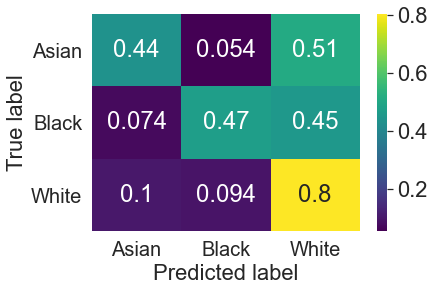

In [236]:
ax = plt.subplot()
sns.set(style="white", font_scale=2.0) # Adjust to fit
g = sns.heatmap(cm, annot=True, ax=ax, cmap='viridis', xticklabels=['Asian', 'Black', 'White']);  
label_font = {'size':'22'}  # Adjust to fit
ax.set_xlabel('Predicted label', fontdict=label_font);
ax.set_ylabel('True label', fontdict=label_font);
g.set_yticklabels(labels=['Asian', 'Black', 'White'], rotation=0) 

plt.show()

In [237]:
precision_a_arr = []
recall_a_arr = []
fscore_a_arr = []

precision_b_arr = []
recall_b_arr = []
fscore_b_arr = []

precision_w_arr = []
recall_w_arr = []
fscore_w_arr = []

for i in range(6):
    precision_a = precision_recall[i][0][0]
    precision_b = precision_recall[i][0][1]
    precision_w = precision_recall[i][0][2]

    recall_a = precision_recall[i][1][0]
    recall_b = precision_recall[i][1][1]
    recall_w = precision_recall[i][1][2]

    fscore_a = precision_recall[i][2][0]
    fscore_b = precision_recall[i][2][1]
    fscore_w = precision_recall[i][2][2]

    precision_a_arr.append(precision_a)
    recall_a_arr.append(recall_a)
    fscore_a_arr.append(fscore_a)
    
    precision_b_arr.append(precision_b)
    recall_b_arr.append(recall_b)
    fscore_b_arr.append(fscore_b)
    
    precision_w_arr.append(precision_w)
    recall_w_arr.append(recall_w)
    fscore_w_arr.append(fscore_w)

In [238]:
np.mean(precision_a_arr)

0.5212501802889177

In [239]:
np.std(precision_a_arr)

0.11150501253445395

In [240]:
np.mean(recall_a_arr)

0.43509096515572

In [241]:
np.std(recall_a_arr)

0.0986843050886847

In [242]:
np.mean(fscore_a_arr)

0.47104141157435625

In [243]:
np.std(fscore_a_arr)

0.09759783673681957

In [244]:
np.mean(precision_b_arr)

0.5722150923370436

In [245]:
np.std(precision_b_arr)

0.06910443729986926

In [246]:
np.mean(recall_b_arr)

0.4716312056737588

In [247]:
np.std(recall_b_arr)

0.04616814393472205

In [248]:
np.mean(fscore_b_arr)

0.516705795527384

In [249]:
np.std(fscore_b_arr)

0.05457108900856621

In [250]:
np.mean(precision_w_arr)

0.7297640826779538

In [251]:
np.std(precision_w_arr)

0.02634465191262829

In [252]:
np.mean(recall_w_arr)

0.8044832694318579

In [253]:
np.std(recall_w_arr)

0.04649636523129019

In [254]:
np.mean(fscore_w_arr)

0.7649412061332307

In [255]:
np.std(fscore_w_arr)

0.0331046553586187